Set parameter Username
Set parameter LicenseID to value 2649317
Academic license - for non-commercial use only - expires 2026-04-09


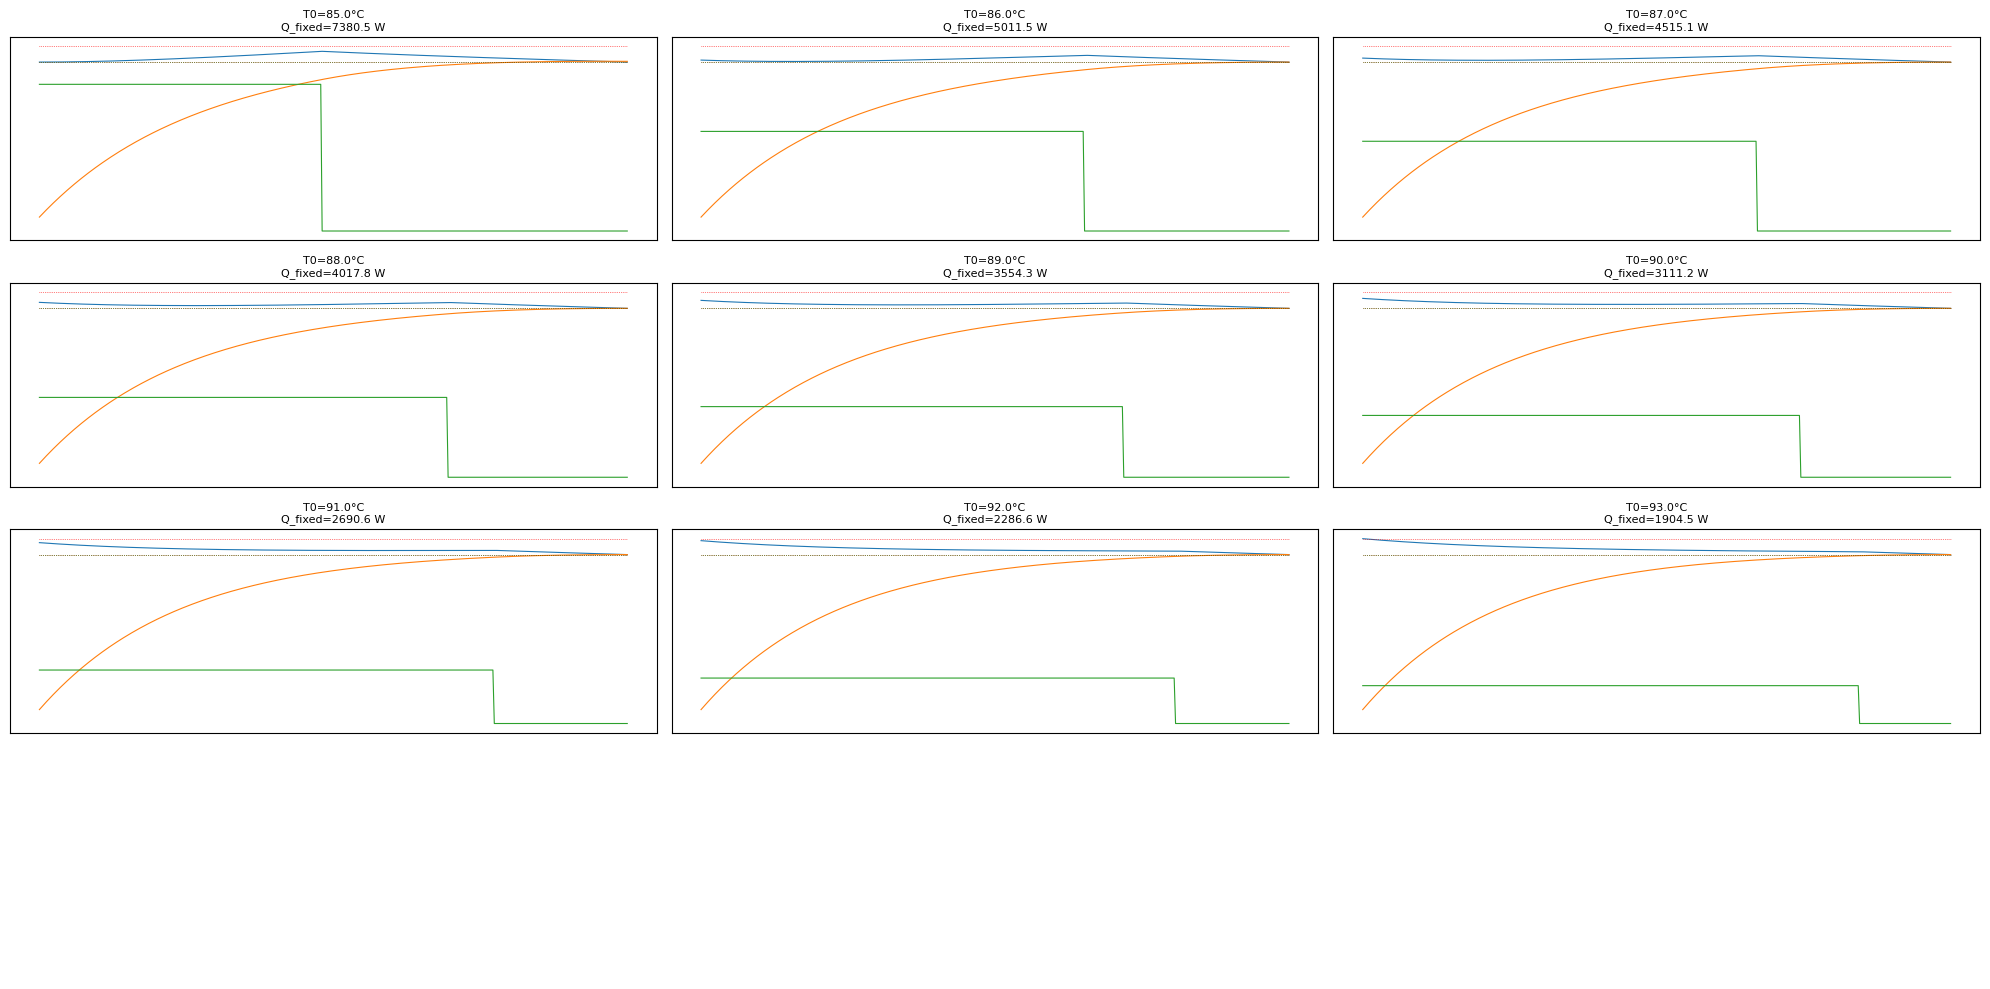

Initial Water Temperature: 85.0 °C, Required Fixed Power: 7380.5 W
Initial Water Temperature: 86.0 °C, Required Fixed Power: 5011.5 W
Initial Water Temperature: 87.0 °C, Required Fixed Power: 4515.1 W
Initial Water Temperature: 88.0 °C, Required Fixed Power: 4017.8 W
Initial Water Temperature: 89.0 °C, Required Fixed Power: 3554.3 W
Initial Water Temperature: 90.0 °C, Required Fixed Power: 3111.2 W
Initial Water Temperature: 91.0 °C, Required Fixed Power: 2690.6 W
Initial Water Temperature: 92.0 °C, Required Fixed Power: 2286.6 W
Initial Water Temperature: 93.0 °C, Required Fixed Power: 1904.5 W


In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Constants
tc_s = 7 * 60        # total cooking time [s]
dt = 1               # time step [s]
n = int(tc_s / dt) + 1
T_env = 20
T_pasta_0 = 7

R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, tc_s, n)
T_water_0_range = np.arange(85.0, 93.1, 1)
Q_fixed_values = []
fig, axs = plt.subplots(4, int(np.ceil(len(T_water_0_range) / 4)), figsize=(20, 10))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n, lb=0, name="Q")
    delta_on = model.addVars(n, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n, lb=0, name="T_water")
    T_pasta = model.addVars(n, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    for t_ in range(1, n):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)
        model.addConstr(z[t_] <= z[t_-1])

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n)) <= 1)

    for i in range(n):
        model.addConstr(Q[i] == Q_fixed * z[i])
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    for i in range(1, n):
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

    model.addConstr(T_pasta[n - 1] >= 85)

    model.setObjective(gp.quicksum(Q[i] * dt for i in range(n)) / 1000, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n)])
        T_water_vals = np.array([T_water[i].X for i in range(n)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.1f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.1f}°C\nNo Solution", fontsize=8)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

#print the initial temperature of the water and the needed fixed power
for i in range(len(T_water_0_range)):
    print(f"Initial Water Temperature: {T_water_0_range[i]:.1f} °C, Required Fixed Power: {Q_fixed_values[i]:.1f} W")

Set parameter Username
Set parameter LicenseID to value 2653942
Academic license - for non-commercial use only - expires 2026-04-17


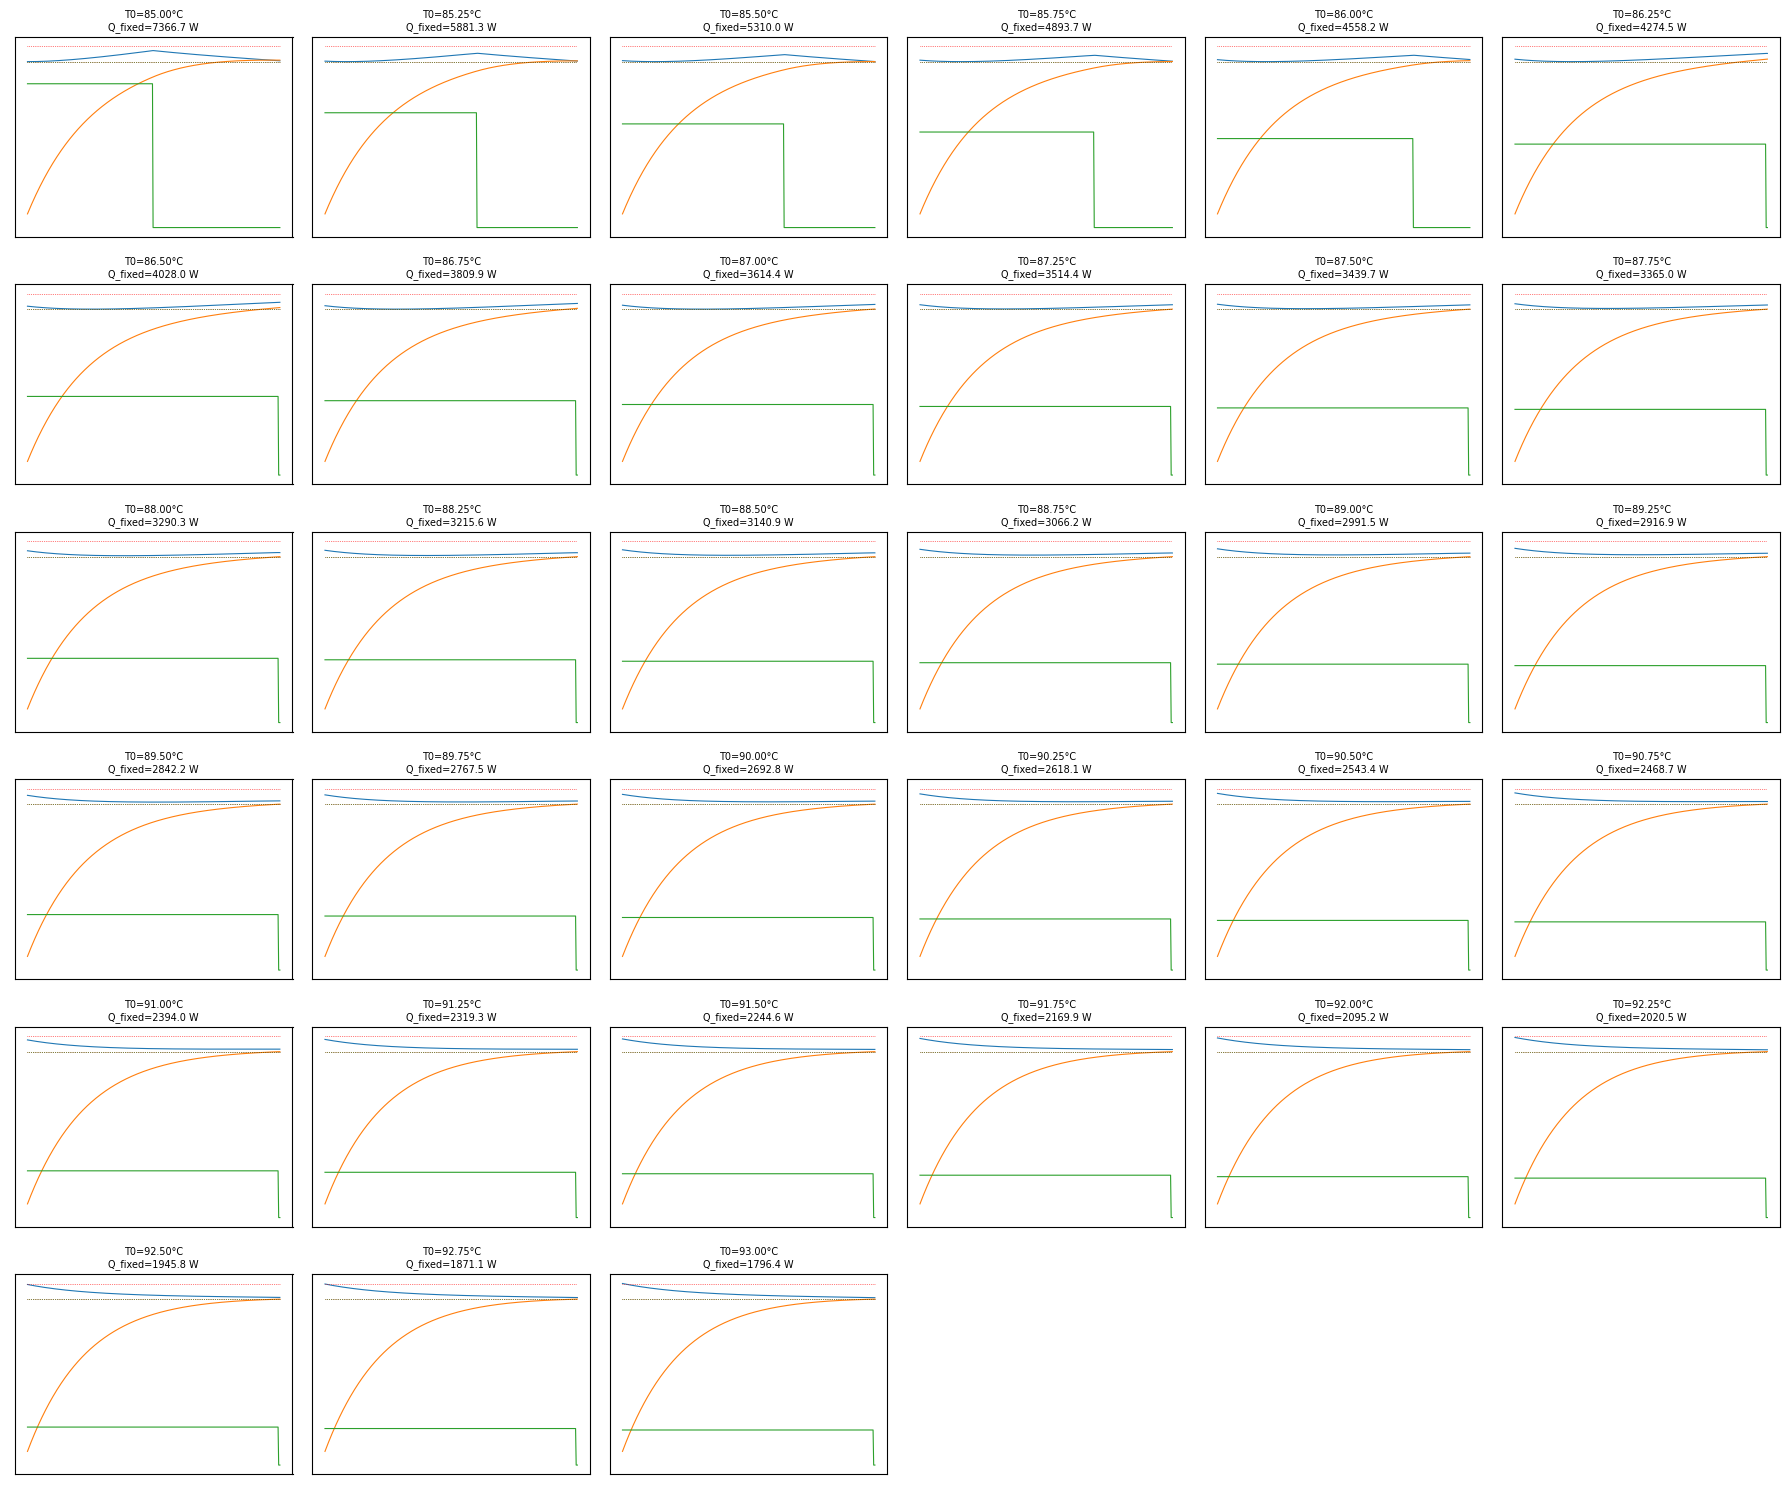

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



📊 Required fixed power vs. initial water temperature:
Initial Water Temperature: 85.00 °C, Required Fixed Power: 7366.7 W
Initial Water Temperature: 85.25 °C, Required Fixed Power: 5881.3 W
Initial Water Temperature: 85.50 °C, Required Fixed Power: 5310.0 W
Initial Water Temperature: 85.75 °C, Required Fixed Power: 4893.7 W
Initial Water Temperature: 86.00 °C, Required Fixed Power: 4558.2 W
Initial Water Temperature: 86.25 °C, Required Fixed Power: 4274.5 W
Initial Water Temperature: 86.50 °C, Required Fixed Power: 4028.0 W
Initial Water Temperature: 86.75 °C, Required Fixed Power: 3809.9 W
Initial Water Temperature: 87.00 °C, Required Fixed Power: 3614.4 W
Initial Water Temperature: 87.25 °C, Required Fixed Power: 3514.4 W
Initial Water Temperature: 87.50 °C, Required Fixed Power: 3439.7 W
Initial Water Temperature: 87.75 °C, Required Fixed Power: 3365.0 W
Initial Water Temperature: 88.00 °C, Required Fixed Power: 3290.3 W
Initial Water Temperature: 88.25 °C, Required Fixed Power: 32

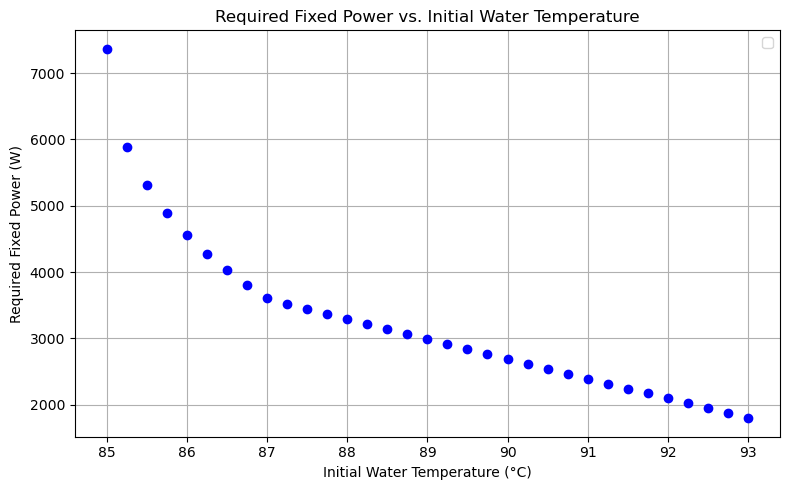

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Constants
tc_s = 7 * 60        # total cooking time [s]
dt = 1               # time step [s]
n = int(tc_s / dt) + 1
T_env = 20
T_pasta_0 = 7

R_env = 30 / 1000    # [K/W]
R_pasta = 15 / 1000  # [K/W]
c_l = 4.18 * 1000    # [J/kg·K]
c_pasta = 3.5 * 1000 # [J/kg·K]

V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1e6  # m^3
m_water = V_water * 1000
m_pasta = 2

C_water = m_water * c_l
C_pasta = m_pasta * c_pasta

t = np.linspace(0, tc_s, n)
T_water_0_range = np.arange(85.0, 93.01, 0.25)
Q_fixed_values = []

fig_cols = 6
fig_rows = int(np.ceil(len(T_water_0_range) / fig_cols))
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols * 3, fig_rows * 2.5))
axs = axs.flatten()

for idx, T_water_0 in enumerate(T_water_0_range):
    model = gp.Model("HeatPumpCooking")
    model.setParam("OutputFlag", 0)

    Q_fixed = model.addVar(lb=0, ub=10000, name="Q_fixed")
    z = model.addVars(n, vtype=GRB.BINARY, name="z")
    Q = model.addVars(n, lb=0, name="Q")
    delta_on = model.addVars(n, vtype=GRB.BINARY, name="delta_on")
    T_water = model.addVars(n, lb=0, name="T_water")
    T_pasta = model.addVars(n, lb=0, name="T_pasta")

    model.addConstr(T_water[0] == T_water_0)
    model.addConstr(T_pasta[0] == T_pasta_0)

    for t_ in range(1, n):
        model.addConstr(delta_on[t_] >= z[t_] - z[t_-1])
        model.addConstr(delta_on[t_] >= 0)
        model.addConstr(delta_on[t_] <= 1)
        model.addConstr(z[t_] <= z[t_-1])

    model.addConstr(gp.quicksum(delta_on[t_] for t_ in range(1, n)) <= 1)

    for i in range(n):
        model.addConstr(Q[i] == Q_fixed * z[i])
        model.addConstr(T_water[i] >= 85)
        model.addConstr(T_water[i] <= 93)

    for i in range(1, n):
        model.addConstr(
            T_water[i] == T_water[i - 1] + dt * (
                Q[i - 1] - (T_water[i - 1] - T_env) / R_env - (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_water
        )
        model.addConstr(
            T_pasta[i] == T_pasta[i - 1] + dt * (
                (T_water[i - 1] - T_pasta[i - 1]) / R_pasta
            ) / C_pasta
        )

    model.addConstr(T_pasta[n - 1] >= 85)
    model.setObjective(Q_fixed, GRB.MINIMIZE)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        Q_vals = np.array([Q[i].X for i in range(n)])
        T_water_vals = np.array([T_water[i].X for i in range(n)])
        T_pasta_vals = np.array([T_pasta[i].X for i in range(n)])
        Q_fixed_val = Q_fixed.X
        Q_fixed_values.append(Q_fixed_val)

        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=0.8)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=0.8)
        ax.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.2f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        Q_fixed_values.append(np.nan)
        axs[idx].set_title(f"T0={T_water_0:.2f}°C\nNo Solution", fontsize=7)
        axs[idx].axis("off")

for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Print results
print("\n📊 Required fixed power vs. initial water temperature:")
for i in range(len(T_water_0_range)):
    print(f"Initial Water Temperature: {T_water_0_range[i]:.2f} °C, Required Fixed Power: {Q_fixed_values[i]:.1f} W")

# Convert to arrays for fitting (filter out NaNs)
T_array = np.array(T_water_0_range)
Q_array = np.array(Q_fixed_values)
mask = ~np.isnan(Q_array)
T_clean = T_array[mask]
Q_clean = Q_array[mask]

# Fit quadratic curve: Q = a*T^2 + b*T + c
coeffs = np.polyfit(T_clean, Q_clean, 2)
fit_fn = np.poly1d(coeffs)

# Plot fitted curve
plt.figure(figsize=(8, 5))
plt.plot(T_clean, Q_clean, 'bo')
T_fit = np.linspace(T_clean.min(), T_clean.max(), 300)
plt.xlabel("Initial Water Temperature (°C)")
plt.ylabel("Required Fixed Power (W)")
plt.title("Required Fixed Power vs. Initial Water Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


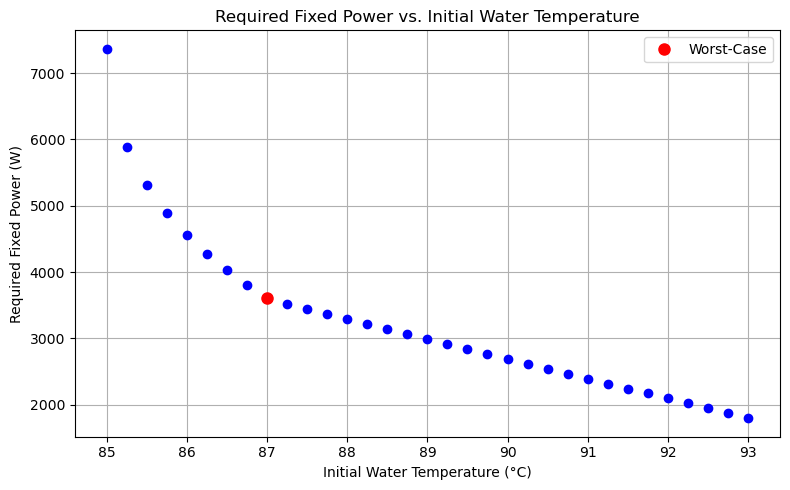

In [6]:
# Convert to arrays for fitting (filter out NaNs)
T_array = np.array(T_water_0_range)
Q_array = np.array(Q_fixed_values)
mask = ~np.isnan(Q_array)
T_clean = T_array[mask]
Q_clean = Q_array[mask]

# Plot data points
plt.figure(figsize=(8, 5))
plt.plot(T_clean, Q_clean, 'bo')

# Highlight the point at 87 °C in red (if 87 is in range)
T_highlight = 87
# Interpolate to get the y-value at T=87
Q_highlight = np.interp(T_highlight, T_clean, Q_clean)
plt.plot(T_highlight, Q_highlight, 'ro', markersize=8, label="Worst-Case")

# Labels and formatting
plt.xlabel("Initial Water Temperature (°C)")
plt.ylabel("Required Fixed Power (W)")
plt.title("Required Fixed Power vs. Initial Water Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


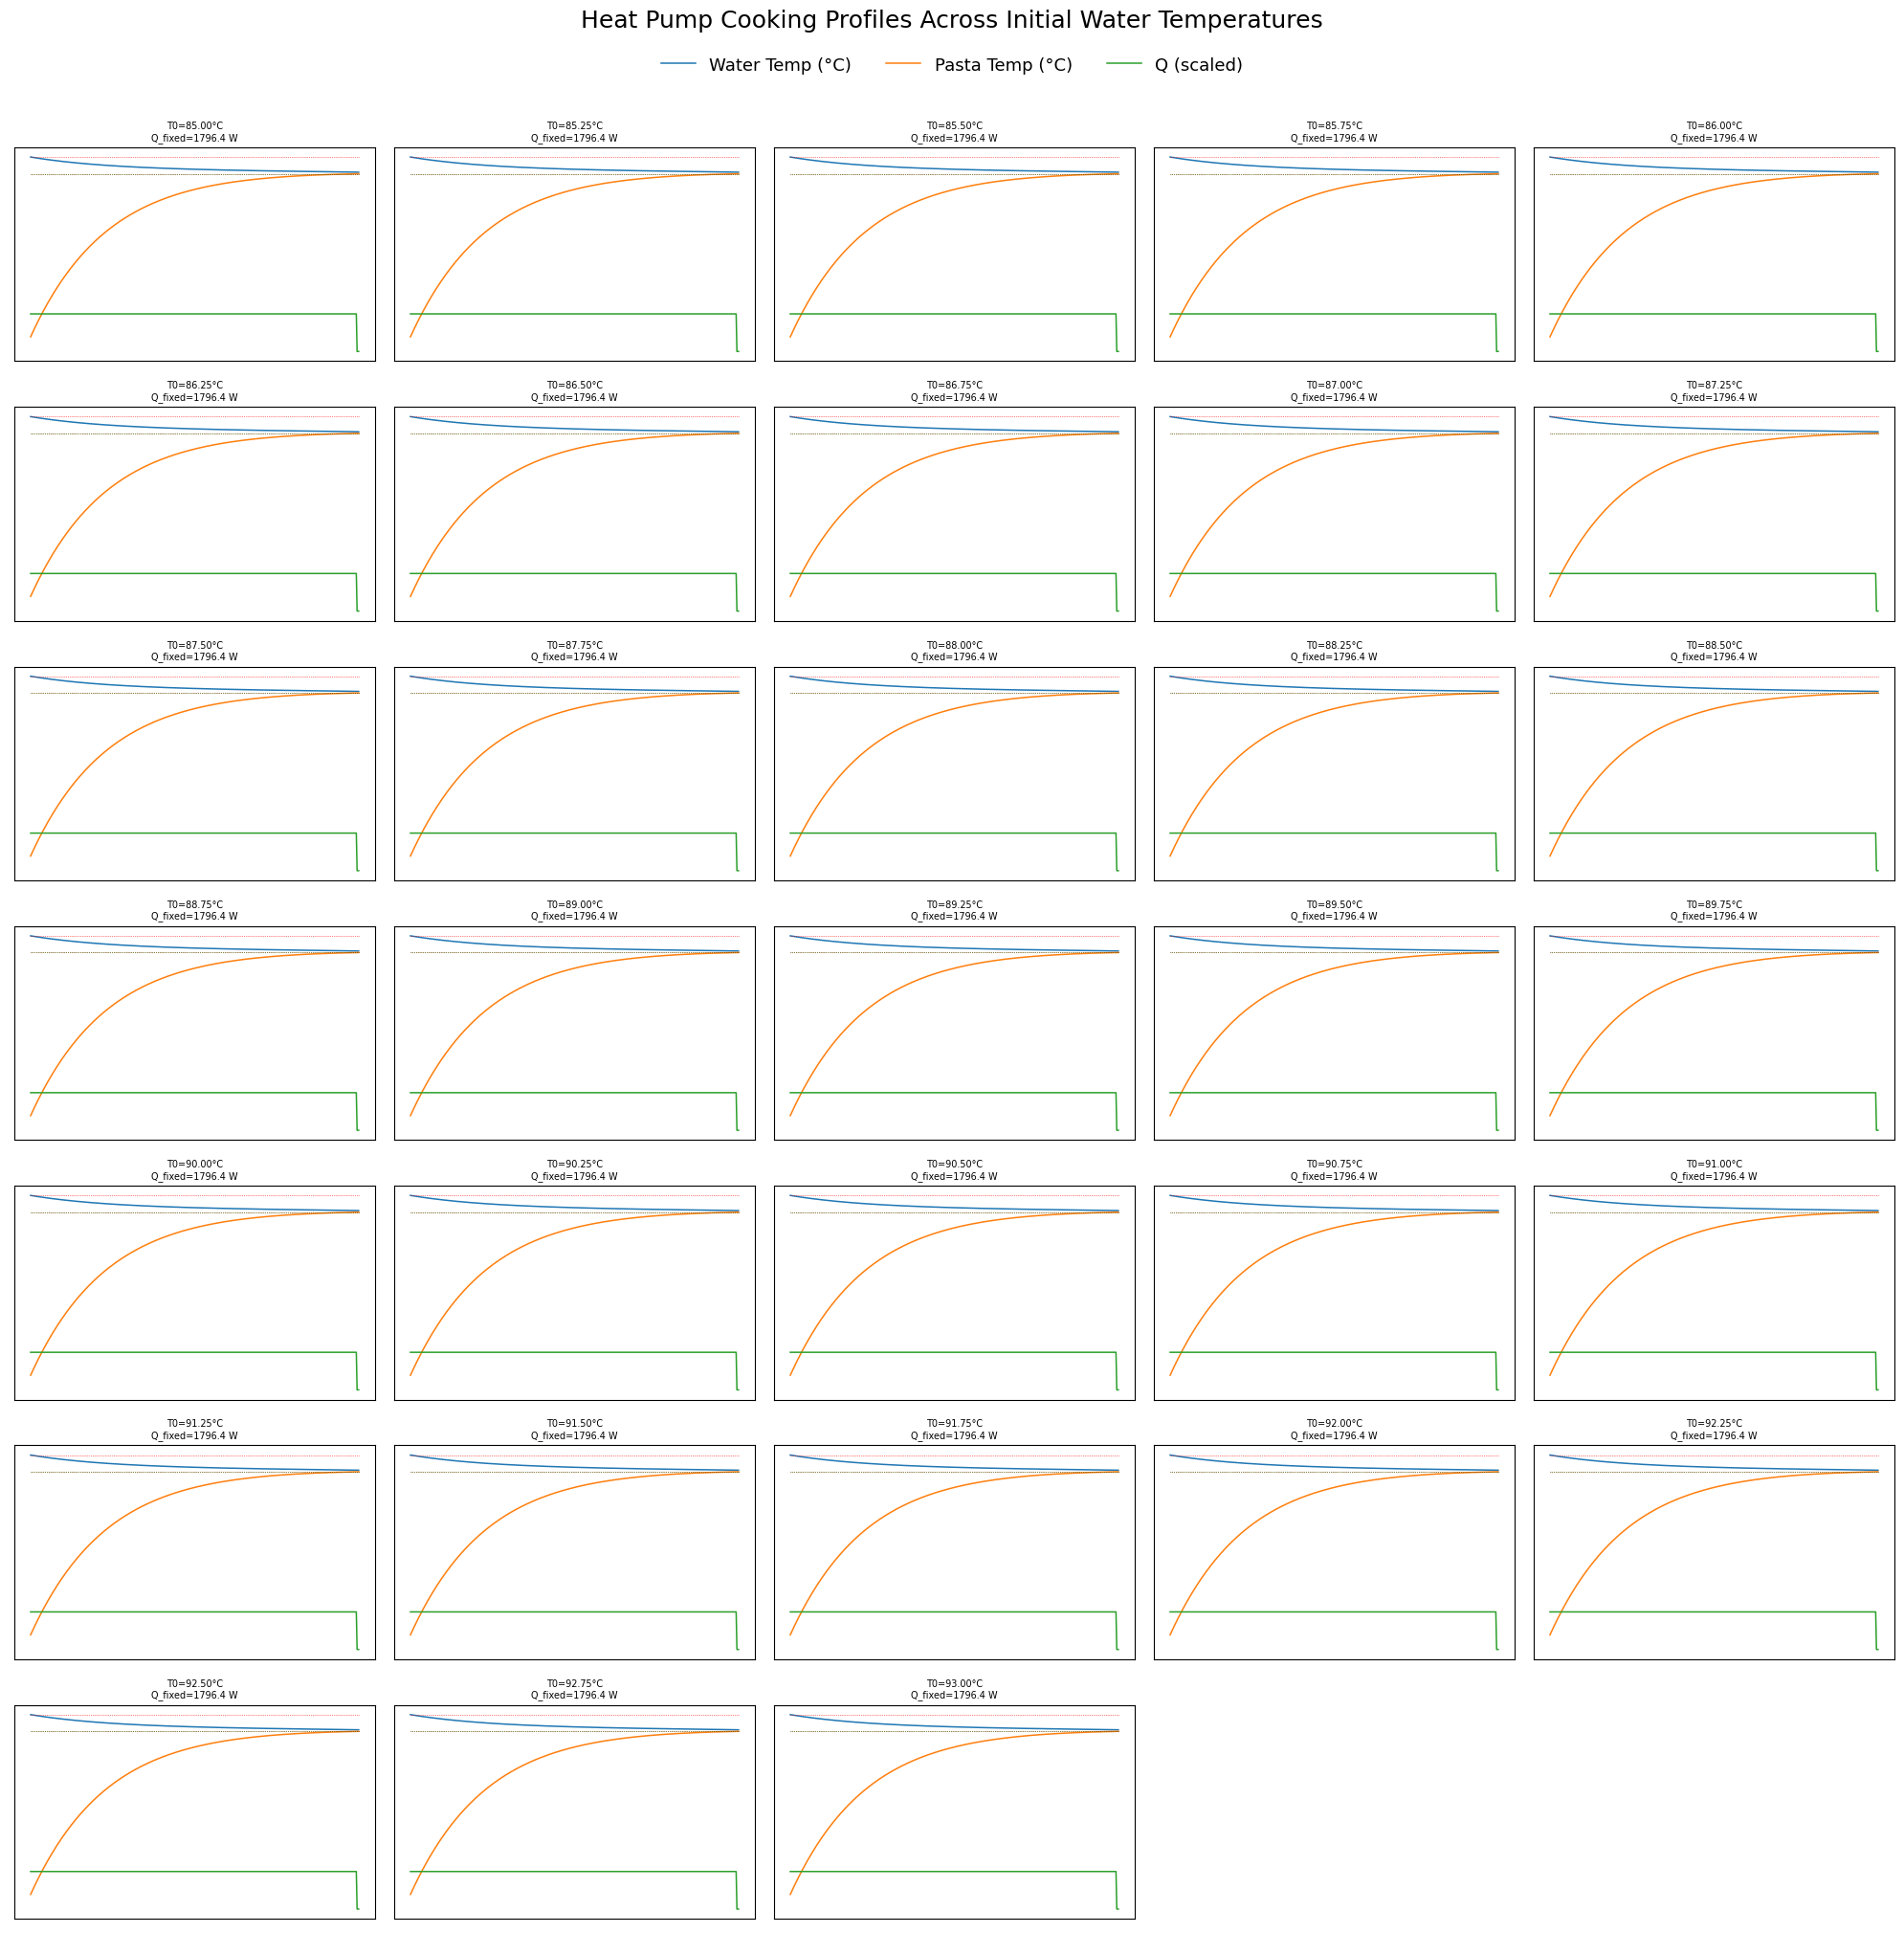

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example variables for structure
fig_cols = 5  # Fewer plots per row
fig_rows = int(np.ceil(len(T_water_0_range) / fig_cols))
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols * 4, fig_rows * 3))
axs = axs.flatten()

# Plotting loop (you already have the model solve part above this)
for idx, T_water_0 in enumerate(T_water_0_range):
    if model.status == GRB.OPTIMAL:
        ax = axs[idx]
        ax.plot(t / 60, T_water_vals, label="Water Temp (°C)", linewidth=1.1)
        ax.plot(t / 60, T_pasta_vals, label="Pasta Temp (°C)", linewidth=1.1)
        ax.plot(t / 60, Q_vals / 100, label="Q (scaled)", linewidth=1.1)
        ax.hlines([85, 93], 0, tc_s / 60, colors='r', linestyles='dotted', linewidth=0.5)
        ax.hlines([85], 0, tc_s / 60, colors='g', linestyles='dotted', linewidth=0.5)
        ax.set_title(f"T0={T_water_0:.2f}°C\nQ_fixed={Q_fixed_val:.1f} W", fontsize=7)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True)
    else:
        axs[idx].set_title(f"T0={T_water_0:.2f}°C\nNo Solution", fontsize=7)
        axs[idx].axis("off")

# Turn off unused axes
for ax in axs[len(T_water_0_range):]:
    ax.axis("off")

# Add a supertitle
fig.suptitle("Heat Pump Cooking Profiles Across Initial Water Temperatures", fontsize=18, y=0.96)

# Collect legend handles from one subplot
handles, labels = axs[0].get_legend_handles_labels()
# Remove duplicates
unique = dict(zip(labels, handles))

# Add shared legend below the title, above the plots
fig.legend(
    unique.values(), unique.keys(),
    loc='lower center',
    ncol=3,
    fontsize=13,
    frameon=False,
    bbox_to_anchor=(0.5, 0.92)  # Just below the title
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space at the top
plt.show()


<Figure size 640x480 with 0 Axes>